In [1]:
#import dependencies
#%matplotlib inline
#from matplotlib import style
#plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Inspect the database

inspector = inspect(engine)
inspector.get_table_names()

# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# query the latest date in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# check latest date in database
latest_date

('2017-08-23')

In [12]:
# getting the the 1-yr prior date to retrieve the previous 1 year data
latestDate = list(np.ravel(latest_date))
LatestDate = dt.datetime.strptime(latestDate[0],'%Y-%m-%d').date()
year_ago = LatestDate - dt.timedelta(days=365)

# check the 1-year date from the latest date
year_ago

datetime.date(2016, 8, 23)

In [13]:
# filter the 1-year data
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(year_ago, LatestDate)).order_by(Measurement.date.desc()).all()

# Unpack the date and prcp from results and save into separate lists
#date = [result[0] for result in results]
#prcp = [result[1] for result in results]

In [14]:
# loading date and precipitation into dataframe
prcp_table = pd.DataFrame(results)

# drop rows with missing prcp
#df = df.dropna()

# set date column as index
prcp_table.set_index('date', inplace=True)

# sort dataframe by index (ascending)
prcp_table.sort_index(ascending=True, inplace=True)

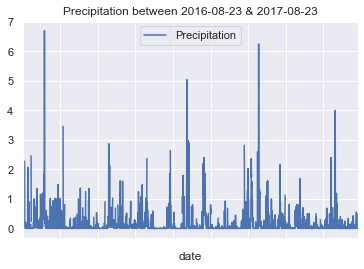

In [15]:
import seaborn as sns
sns.set()

# Plot the dataframe as bar chart using pandas plotting
ax = prcp_table.plot(title = 'Precipitation between ' + prcp_table.first_valid_index() + ' & ' + latest_date[0])

ax.xaxis.set_major_formatter(plt.NullFormatter())

# add formatting
ax.legend(["Precipitation"]);

In [16]:
prcp_table.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement).distinct(Measurement.station).group_by(Measurement.station).count()
print("There are " + str(station_count) + " stations in this dataset.")

There are 9 stations in this dataset.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

obs_n = func.count(Measurement.station)

station_list = session.query(Measurement.station, Station.name, obs_n).\
                    join(Measurement, Measurement.station == Station.station).group_by(Measurement.station).\
                    order_by(obs_n.desc()).all()

# Display the list
for station in station_list:
    print("There are " + str(station[2]) + " of observations at " + station[1] + " (" + station[0] + ").")

There are 2772 of observations at WAIHEE 837.5, HI US (USC00519281).
There are 2724 of observations at WAIKIKI 717.2, HI US (USC00519397).
There are 2709 of observations at KANEOHE 838.1, HI US (USC00513117).
There are 2669 of observations at WAIMANALO EXPERIMENTAL FARM, HI US (USC00519523).
There are 2612 of observations at MANOA LYON ARBO 785.2, HI US (USC00516128).
There are 2202 of observations at KUALOA RANCH HEADQUARTERS 886.9, HI US (USC00514830).
There are 1979 of observations at HONOLULU OBSERVATORY 702.2, HI US (USC00511918).
There are 1372 of observations at PEARL CITY, HI US (USC00517948).
There are 511 of observations at UPPER WAHIAWA 874.3, HI US (USC00518838).


In [19]:
# Get the station with highest number of observations
highest_obs = session.query(Measurement.station, Station.name, obs_n).\
                    join(Measurement, Measurement.station == Station.station).group_by(Measurement.station).\
                    order_by(obs_n.desc()).first()

statement = "The station with the highest number of observations is "\
            + highest_obs[1] + " (" + highest_obs[0] + "), with a count of " + str(highest_obs[2]) + "!"

# Get the average temperature of the station with the highest number of observations
avg_temp = session.query(func.avg(Measurement.tobs)).\
                    filter(Measurement.station == highest_obs[0])
average_temp = round(avg_temp[0][0],1)

# Get the highest temperature of the station with the highest number of observations
max_temp = session.query(func.max(Measurement.tobs)).\
                    filter(Measurement.station == highest_obs[0])
highest_temp = round(max_temp[0][0],1)

# Get the lowest temperature of the station with the highest number of observations
min_temp = session.query(func.min(Measurement.tobs)).\
                    filter(Measurement.station == highest_obs[0])
lowest_temp = round(min_temp[0][0],1)

print(statement)
print("The average temperature recorded at " + highest_obs[1] + " is " + str(average_temp) + ".")
print("The highest temperature recorded at " + highest_obs[1] + " is " + str(highest_temp) + ".")
print("The highest temperature recorded at " + highest_obs[1] + " is " + str(lowest_temp) + ".")

The station with the highest number of observations is WAIHEE 837.5, HI US (USC00519281), with a count of 2772!
The average temperature recorded at WAIHEE 837.5, HI US is 71.7.
The highest temperature recorded at WAIHEE 837.5, HI US is 85.0.
The highest temperature recorded at WAIHEE 837.5, HI US is 54.0.


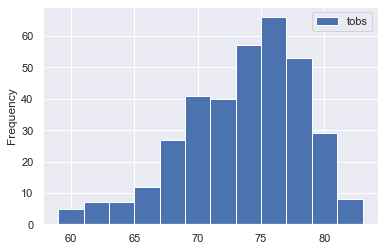

In [20]:
# Get the tobs of station with highest number of obs
obs_highest_tobs = session.query(Measurement.station, Measurement.tobs).\
                    filter(Measurement.station == highest_obs[0]).\
                    filter(Measurement.date.between(year_ago,LatestDate)).\
                    order_by(Measurement.tobs).all()

tobs_df = pd.DataFrame(obs_highest_tobs)
tobs_df.set_index('station', inplace=True)

# Plot results as histogram
tobs_df.plot.hist(bins=12);

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
mytrip = f"2020-02-15 to 2020-02-22"
start_date = '2017-02-15'
end_date = '2017-02-22'

print(calc_temps(start_date,end_date))
temp = calc_temps(start_date,end_date)

[(65.0, 71.1875, 77.0)]


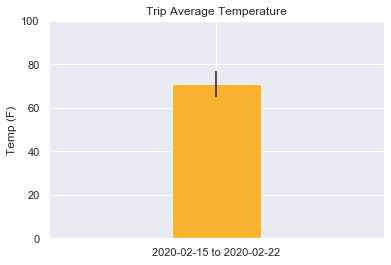

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tave = temp[0][1]
tmin = temp[0][0]
tmax = temp[0][2]

min_error = tave - tmin
max_error = tmax - tave

yerr = np.array([[min_error], [max_error]])

label = mytrip

plt.bar(label,tave, color="orange", yerr=yerr, alpha = 0.8)
plt.title("Trip Average Temperature")
plt.ylim(0,100)
plt.xlim(-1.5,1.5)
plt.ylabel('Temp (F)');

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_prcp = func.sum(Measurement.prcp)
rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, total_prcp).\
                    join(Measurement, Measurement.station == Station.station).\
                    filter(Measurement.date.between(start_date,end_date)).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

# Unpack the data
rainfall_station = [result[0] for result in rainfall]
rainfall_station_name = [result[1] for result in rainfall]
rainfall_latitude = [result[2] for result in rainfall]
rainfall_longitude = [result[3] for result in rainfall]
rainfall_elevation = [result[4] for result in rainfall]
rainfall_prcp = [result[5] for result in rainfall]

rainfall_df = pd.DataFrame(
    {'Station': rainfall_station,
     'Station Name': rainfall_station_name,
     'Latitude': rainfall_latitude,
     'Longitude': rainfall_longitude,
     'Elevation': rainfall_elevation,
     'Total Rainfall': rainfall_prcp
    })

rainfall_df

,Station,Station Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.02
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.87
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.86
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.79
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.69
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.19
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.17


# Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# creating an empty list to store the tuple of calculations
normals = []

# using the same start and end date as previously
mytrip = f"2020-02-15 to 2020-02-20"
start_date = '2017-02-15'
end_date = '2017-02-22'

# Use the start and end date to create a range of dates
date_list = []

d1 = dt.datetime.strptime(start_date, "%Y-%m-%d")
d2 = dt.datetime.strptime(end_date, "%Y-%m-%d")
days = [d1 + dt.timedelta(days=x) for x in range((d2-d1).days + 1)]

for day in days:
    date_list.append(day.strftime('%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_list:
    normals.append(daily_normals(date))

In [27]:
# putting the normals data into a dataframe
column = ["TMIN","TAVE","TMAX"]

normals = [np.array(normal[0]) for normal in normals]
normals_df = pd.DataFrame(normals, columns = column)

# adding in the date
normals_df['date'] = date_list
normals_df.set_index('date', inplace = True)

# check dataframe
normals_df

,TMIN,TAVE,TMAX
date,,,
02-15,56.0,70.288136,79.0
02-16,59.0,70.482143,76.0
02-17,62.0,70.472727,77.0
02-18,63.0,70.796296,77.0
02-19,60.0,69.339623,77.0
02-20,63.0,70.140351,76.0
02-21,63.0,69.796296,76.0
02-22,60.0,70.157895,83.0


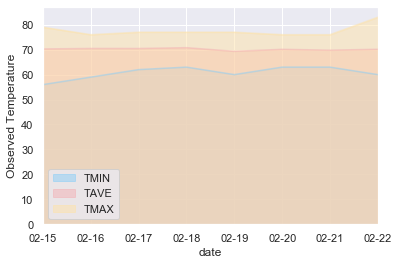

In [28]:
# plot chart

pal = ["#89CEF8", "#F3B0B5", "#FEE3A9"]
normals_df.plot.area(stacked=False, color = pal)
plt.ylabel('Observed Temperature');